<a href="https://colab.research.google.com/github/sravanmedarametla/Walmart/blob/main/walmart_Coding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
from IPython.display import display, HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [75]:
!pip install findspark

In [76]:
!pip install -q pyspark

In [77]:
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

#### Importing packages

In [78]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as fxn
from pyspark.sql.types import StructType, StructField, StringType, IntegerType,FloatType


In [79]:
import warnings

warnings.filterwarnings('ignore')

In [80]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
from pyspark import SparkConf

# Configure Spark to set the log level to ERROR (or any other desired level)
conf = SparkConf().set("spark.logConf", "true").set("spark.log.level", "WARN")
# Create a Spark session
spark = SparkSession.builder.config(conf=conf).appName("Walmart data analytics").getOrCreate()


df = spark.read.format("csv").option("header","true").option("multiLine","true").\
option("escape","\"").load("drive/MyDrive/walmart_data.csv")
df = df.withColumn("index", fxn.monotonically_increasing_id())

df = df.select("index","Uniq Id","Crawl Timestamp","Product Url","Product Name","Description","List Price","Sale Price",
"Brand","Item Number","Gtin","Package Size","Category","Postal Code","Available")

df.show(10)

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+----------+---------------+-----------+-------------+------------+--------------------+-----------+---------+
|index|             Uniq Id|     Crawl Timestamp|         Product Url|        Product Name|         Description|List Price|Sale Price|          Brand|Item Number|         Gtin|Package Size|            Category|Postal Code|Available|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+----------+---------------+-----------+-------------+------------+--------------------+-----------+---------+
|    0|51b010b871cde349b...|2020-01-24 16:08:...|https://www.walma...|Allegiance Econom...| We aim to show y...|     11.11|     11.11|Cardinal Health|       NULL|0707389636164|        NULL|Health | Medicine...|       NULL|     TRUE|
|    1|d6a7f100e44a626a3...|2020-01-24 15:54:...|https://www.walma..

In [82]:
last = df.tail(5)
last


[Row(index=29995, Uniq Id='08800cf3c19fa9d4c6f33e7b0fba0020', Crawl Timestamp='2020-01-24 19:35:05 +0000', Product Url='https://www.walmart.com/ip/Inside-Groin-Cup-with-Supporter/127343787', Product Name='Inside Groin Cup with Supporter', Description=' We aim to show you accurate product information. Manufacturers, suppliers and others provide what you see here, and we have not verified it. See our disclaimer |Inside Groin Cup with Supporter \xa0 Inside Groin Cup with Supporter Specifications Can be used in virtually all contact sports including boxing, football, and martial arts Comfortable, secure fit Features an extra wide elastic waist The inside groin protector is designed to conform and fit you comfortable. The inside groin protector features a wide elastic waistband to fit you securely and for easy adjustment. \xa0 ', List Price='6.95', Sale Price='6.95', Brand='Ace Martial Arts Supply', Item Number=None, Gtin='0615953380446', Package Size=None, Category='Sports & Outdoors | Spo

In [83]:
spark

In [84]:
# spark --version
spark.version

'3.5.0'

In [85]:

saledf = df
saledf = saledf.withColumn('type_description_new',
                   fxn.when(fxn.col('List Price')!=fxn.col('Sale Price'),
                                               fxn.lit('False')).otherwise(fxn.lit('True')))
saledf.show(truncate=False)

+-----+--------------------------------+-------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [86]:
saledf.groupBy('type_description_new').count().orderBy('count').show()

+--------------------+-----+
|type_description_new|count|
+--------------------+-----+
|               False| 1273|
|                True|28727|
+--------------------+-----+



In [87]:
saledf.printSchema()


root
 |-- index: long (nullable = false)
 |-- Uniq Id: string (nullable = true)
 |-- Crawl Timestamp: string (nullable = true)
 |-- Product Url: string (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- List Price: string (nullable = true)
 |-- Sale Price: string (nullable = true)
 |-- Brand: string (nullable = true)
 |-- Item Number: string (nullable = true)
 |-- Gtin: string (nullable = true)
 |-- Package Size: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Postal Code: string (nullable = true)
 |-- Available: string (nullable = true)
 |-- type_description_new: string (nullable = false)



### Null Count Check


In [88]:
def Nullvalues(df):
    NullDict = {}
    for clmn in df.columns:
        NullCnt = df.select(fxn.count(fxn.when(fxn.isnull(clmn), clmn)).\
                            alias('NullCnt')).collect()[0]['NullCnt']
        NullDict[clmn] = NullCnt
        data_list = [(index, column, null_count) for index, (column, null_count) in enumerate(NullDict.items())]

# Define the schema for the DataFrame
        schema = StructType([
            StructField("Index", IntegerType(), True),
            StructField("Column", StringType(), True),
            StructField("Null Count", IntegerType(), True)
        ])


        NullDF = spark.createDataFrame(data_list,schema)


    return NullDF.show()

In [89]:
%%time
print("Null Count Check in walmart Data :")
Nullvalues(saledf)

Null Count Check in walmart Data :
+-----+--------------------+----------+
|Index|              Column|Null Count|
+-----+--------------------+----------+
|    0|               index|         0|
|    1|             Uniq Id|         0|
|    2|     Crawl Timestamp|         0|
|    3|         Product Url|         0|
|    4|        Product Name|         0|
|    5|         Description|         0|
|    6|          List Price|         0|
|    7|          Sale Price|         0|
|    8|               Brand|       511|
|    9|         Item Number|     21446|
|   10|                Gtin|         0|
|   11|        Package Size|     30000|
|   12|            Category|        24|
|   13|         Postal Code|     30000|
|   14|           Available|         0|
|   15|type_description_new|         0|
+-----+--------------------+----------+

CPU times: user 380 ms, sys: 62.3 ms, total: 442 ms
Wall time: 34.6 s


### Dropping Unnecessary Columns

In [90]:
drop_df  = df.drop('Uniq Id','Product Url','Item Number','Gtin','Package Size')
drop_df.show(10 )

+-----+--------------------+--------------------+--------------------+----------+----------+---------------+--------------------+-----------+---------+
|index|     Crawl Timestamp|        Product Name|         Description|List Price|Sale Price|          Brand|            Category|Postal Code|Available|
+-----+--------------------+--------------------+--------------------+----------+----------+---------------+--------------------+-----------+---------+
|    0|2020-01-24 16:08:...|Allegiance Econom...| We aim to show y...|     11.11|     11.11|Cardinal Health|Health | Medicine...|       NULL|     TRUE|
|    1|2020-01-24 15:54:...|Kenneth Cole Reac...| We aim to show y...|     23.99|     23.99|   Kenneth Cole|Premium Beauty | ...|       NULL|     TRUE|
|    2|2020-01-24 18:34:...|Kid Tough Fitness...| We aim to show y...|     30.76|     30.76|       BONK FIT|Sports & Outdoors...|       NULL|     TRUE|
|    3|2020-01-24 11:08:...|     THE FIRST YEARS| We aim to show y...|      6.99|      6

In [91]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
datedf = drop_df.withColumn("Date", fxn.to_date("Crawl Timestamp", 'yyyy-MM-dd'))

# Extract year, month, and day
datedf = datedf.withColumn("Year", fxn.year("Date"))
datedf = datedf.withColumn("Month", fxn.month("Date"))

datedf = datedf.drop('Crawl Timestamp','Date')

datedf.show(10)

+-----+--------------------+--------------------+----------+----------+---------------+--------------------+-----------+---------+----+-----+
|index|        Product Name|         Description|List Price|Sale Price|          Brand|            Category|Postal Code|Available|Year|Month|
+-----+--------------------+--------------------+----------+----------+---------------+--------------------+-----------+---------+----+-----+
|    0|Allegiance Econom...| We aim to show y...|     11.11|     11.11|Cardinal Health|Health | Medicine...|       NULL|     TRUE|2020|    1|
|    1|Kenneth Cole Reac...| We aim to show y...|     23.99|     23.99|   Kenneth Cole|Premium Beauty | ...|       NULL|     TRUE|2020|    1|
|    2|Kid Tough Fitness...| We aim to show y...|     30.76|     30.76|       BONK FIT|Sports & Outdoors...|       NULL|     TRUE|2020|    1|
|    3|     THE FIRST YEARS| We aim to show y...|      6.99|      6.99|The First Years|Baby | Diapering ...|       NULL|     TRUE|2020|    1|
|    4

In [92]:
Nullvalues(datedf)

+-----+------------+----------+
|Index|      Column|Null Count|
+-----+------------+----------+
|    0|       index|         0|
|    1|Product Name|         0|
|    2| Description|         0|
|    3|  List Price|         0|
|    4|  Sale Price|         0|
|    5|       Brand|       511|
|    6|    Category|        24|
|    7| Postal Code|     30000|
|    8|   Available|         0|
|    9|        Year|         0|
|   10|       Month|         0|
+-----+------------+----------+



In [93]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
split_col = fxn.split(datedf['Category'], "\|")

# Determine the number of parts in the split
num_parts = fxn.size(split_col)

# Create new columns with trimmed values
main_df = datedf.withColumn('Main_Category', split_col.getItem(0))
main_df = main_df.withColumn('Product_Type', split_col.getItem(num_parts-1))
main_df = main_df.drop('Category')
main_df.show(10)

+-----+--------------------+--------------------+----------+----------+---------------+-----------+---------+----+-----+------------------+--------------------+
|index|        Product Name|         Description|List Price|Sale Price|          Brand|Postal Code|Available|Year|Month|     Main_Category|        Product_Type|
+-----+--------------------+--------------------+----------+----------+---------------+-----------+---------+----+-----+------------------+--------------------+
|    0|Allegiance Econom...| We aim to show y...|     11.11|     11.11|Cardinal Health|       NULL|     TRUE|2020|    1|           Health | Digital Thermome...|
|    1|Kenneth Cole Reac...| We aim to show y...|     23.99|     23.99|   Kenneth Cole|       NULL|     TRUE|2020|    1|   Premium Beauty |     Premium Perfume|
|    2|Kid Tough Fitness...| We aim to show y...|     30.76|     30.76|       BONK FIT|       NULL|     TRUE|2020|    1|Sports & Outdoors | All Hunting Clot...|
|    3|     THE FIRST YEARS| We ai

## Postal code data

In [94]:
schema = StructType([
    StructField("store_id", StringType(), True),
    StructField("postal_code", StringType(), True),
    StructField("address", StringType(), True)
])
Zipcodedf = spark.read.option("multiline","true").json('drive/MyDrive/walmart-stores.json',schema=schema)
Zipcodedf.show(truncate=False)

+--------+-----------+------------------------------------------+
|store_id|postal_code|address                                   |
+--------+-----------+------------------------------------------+
|1158    |35214      |2473 Hackworth Rd, Adamsville, AL 35214   |
|4756    |35007      |9085 Hwy 119                              |
|423     |35007      |630 Colonial Promenade Pkwy               |
|726     |35010      |2643 Highway 280, Alexander City, AL 35010|
|1091    |36420      |1991 M. L. King Jr., Andalusia, AL 36420  |
|329     |36206      |5560 Mcclellan Blvd, Anniston, AL 36206   |
|306     |35016      |1450 No. Brindlee Mt, Arab, AL 35016      |
|661     |35611      |1011 Us Highway 72 E, Athens, AL 35611    |
|7247    |36502      |911 N Main St, Atmore, AL 36502           |
|316     |35954      |973 Gilbert Ferry Rd Se, Attalla, AL 35954|
|4673    |36832      |1810 Shug Jordan Parkway                  |
|5062    |36830      |2047 E University Dr                      |
|356     |

In [95]:

import random as rnd

US_postalcodes = [PC['postal_code'] for PC in Zipcodedf.select('postal_code').distinct().collect()]

rnd.seed(42)

schema = StructType([StructField("PostalCode", IntegerType(), True)])
rndPC = rnd.choices(US_postalcodes,k=30000)
PC_Data = [(int(postal_code),) for postal_code in rndPC]

pc_df = spark.createDataFrame(data=PC_Data,schema=schema)
pc_df.show(6)


+----------+
|PostalCode|
+----------+
|     80239|
|     62565|
|     63857|
|     18020|
|     27610|
|     31061|
+----------+
only showing top 6 rows



In [96]:
!pip install pgeocode

In [97]:
import pgeocode
nomi = pgeocode.Nominatim('us')

ps = nomi.query_postal_code(US_postalcodes)
Postcodedf = spark.createDataFrame(ps[['postal_code','state_name']])
Postcodedf.show(10)

+-----------+----------+
|postal_code|state_name|
+-----------+----------+
|      36526|   Alabama|
|      35640|   Alabama|
|      72472|  Arkansas|
|      91910|California|
|      92027|California|
|      33174|   Florida|
|      32773|   Florida|
|      61354|  Illinois|
|      47960|   Indiana|
|      66762|    Kansas|
+-----------+----------+
only showing top 10 rows



In [98]:
zpcd_df = pc_df.join(Postcodedf,pc_df["PostalCode"] == Postcodedf["postal_code"], how="left")
zpcd_df= zpcd_df.drop('postal_code')
zpcd_df.show(10)

+----------+--------------+
|PostalCode|    state_name|
+----------+--------------+
|      2771| Massachusetts|
|     12303|      New York|
|     13601|      New York|
|     18020|  Pennsylvania|
|     27573|North Carolina|
|     27610|North Carolina|
|     28021|North Carolina|
|     30125|       Georgia|
|     30338|       Georgia|
|     31061|       Georgia|
+----------+--------------+
only showing top 10 rows



In [99]:
zpcd_df.count()

30000

In [100]:
zipcode= zpcd_df.withColumn("index", fxn.monotonically_increasing_id())
zipcode.show(5)

+----------+----------+-----+
|PostalCode|state_name|index|
+----------+----------+-----+
|     74820|  Oklahoma|    0|
|     21220|  Maryland|    1|
|     75149|     Texas|    2|
|     44906|      Ohio|    3|
|     49855|  Michigan|    4|
+----------+----------+-----+
only showing top 5 rows



In [101]:
a = zipcode.tail(5)
a

[Row(PostalCode=35768, state_name='Alabama', index=29995),
 Row(PostalCode=35768, state_name='Alabama', index=29996),
 Row(PostalCode=65706, state_name='Missouri', index=29997),
 Row(PostalCode=30314, state_name='Georgia', index=29998),
 Row(PostalCode=86004, state_name='Arizona', index=29999)]

In [102]:
zipcode.show(5)
main_df.show(5)

+----------+----------+-----+
|PostalCode|state_name|index|
+----------+----------+-----+
|     74820|  Oklahoma|    0|
|     21220|  Maryland|    1|
|     75149|     Texas|    2|
|     44906|      Ohio|    3|
|     49855|  Michigan|    4|
+----------+----------+-----+
only showing top 5 rows

+-----+--------------------+--------------------+----------+----------+---------------+-----------+---------+----+-----+------------------+--------------------+
|index|        Product Name|         Description|List Price|Sale Price|          Brand|Postal Code|Available|Year|Month|     Main_Category|        Product_Type|
+-----+--------------------+--------------------+----------+----------+---------------+-----------+---------+----+-----+------------------+--------------------+
|    0|Allegiance Econom...| We aim to show y...|     11.11|     11.11|Cardinal Health|       NULL|     TRUE|2020|    1|           Health | Digital Thermome...|
|    1|Kenneth Cole Reac...| We aim to show y...|     23.99| 

In [103]:
walmartdf= main_df.join(zipcode, on ='index',how='left')
walmartdf = walmartdf.drop('Postal Code')
walmartdf.show(5)

+-----+--------------------+--------------------+----------+----------+---------------+---------+----+-----+------------------+--------------------+----------+----------+
|index|        Product Name|         Description|List Price|Sale Price|          Brand|Available|Year|Month|     Main_Category|        Product_Type|PostalCode|state_name|
+-----+--------------------+--------------------+----------+----------+---------------+---------+----+-----+------------------+--------------------+----------+----------+
|    0|Allegiance Econom...| We aim to show y...|     11.11|     11.11|Cardinal Health|     TRUE|2020|    1|           Health | Digital Thermome...|     74820|  Oklahoma|
|    1|Kenneth Cole Reac...| We aim to show y...|     23.99|     23.99|   Kenneth Cole|     TRUE|2020|    1|   Premium Beauty |     Premium Perfume|     21220|  Maryland|
|    2|Kid Tough Fitness...| We aim to show y...|     30.76|     30.76|       BONK FIT|     TRUE|2020|    1|Sports & Outdoors | All Hunting Clot.

In [104]:
walmartdf.printSchema()

root
 |-- index: long (nullable = false)
 |-- Product Name: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- List Price: string (nullable = true)
 |-- Sale Price: string (nullable = true)
 |-- Brand: string (nullable = true)
 |-- Available: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Main_Category: string (nullable = true)
 |-- Product_Type: string (nullable = true)
 |-- PostalCode: integer (nullable = true)
 |-- state_name: string (nullable = true)



In [105]:
walmartdf = walmartdf.withColumn("List Price",fxn.col("List Price").cast(IntegerType())) \
    .withColumn("Sale Price",fxn.col("Sale Price").cast(IntegerType()))
walmartdf.printSchema()

root
 |-- index: long (nullable = false)
 |-- Product Name: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- List Price: integer (nullable = true)
 |-- Sale Price: integer (nullable = true)
 |-- Brand: string (nullable = true)
 |-- Available: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Main_Category: string (nullable = true)
 |-- Product_Type: string (nullable = true)
 |-- PostalCode: integer (nullable = true)
 |-- state_name: string (nullable = true)



In [106]:
print(Nullvalues(walmartdf))
print("count of walmart data :",walmartdf.count())

walmartdf = walmartdf.na.drop()
print("count of walmart data after removing null rows:",walmartdf.count())
Nullvalues(walmartdf)

+-----+-------------+----------+
|Index|       Column|Null Count|
+-----+-------------+----------+
|    0|        index|         0|
|    1| Product Name|         0|
|    2|  Description|         0|
|    3|   List Price|         0|
|    4|   Sale Price|         0|
|    5|        Brand|       511|
|    6|    Available|         0|
|    7|         Year|         0|
|    8|        Month|         0|
|    9|Main_Category|        24|
|   10| Product_Type|        24|
|   11|   PostalCode|         0|
|   12|   state_name|         0|
+-----+-------------+----------+

None
count of walmart data : 30000
count of walmart data after removing null rows: 29465
+-----+-------------+----------+
|Index|       Column|Null Count|
+-----+-------------+----------+
|    0|        index|         0|
|    1| Product Name|         0|
|    2|  Description|         0|
|    3|   List Price|         0|
|    4|   Sale Price|         0|
|    5|        Brand|         0|
|    6|    Available|         0|
|    7|         Yea

In [107]:
brand_counts = walmartdf.groupBy("Brand").agg(fxn.count("Brand").alias("count"))

# Filter brands that occur more than 3 times
brands_to_keep = brand_counts.filter(fxn.col("count") > 3).select("Brand")

print("Total Number of Brands that are occurred more than 3 times : ",brands_to_keep.count())
walmartdf = walmartdf.join(brands_to_keep, "Brand", "inner")

# Show the result
walmartdf.show()

Total Number of Brands that are occurred more than 3 times :  1583
+--------------------+-----+--------------------+--------------------+----------+----------+---------+----+-----+------------------+--------------------+----------+--------------+
|               Brand|index|        Product Name|         Description|List Price|Sale Price|Available|Year|Month|     Main_Category|        Product_Type|PostalCode|    state_name|
+--------------------+-----+--------------------+--------------------+----------+----------+---------+----+-----+------------------+--------------------+----------+--------------+
|        Alka-Seltzer| 4894|Alka-Seltzer Orig...|We aim to show yo...|         9|         9|     TRUE|2020|    3|           Health | Alka-Seltzer Eff...|     30274|       Georgia|
|Skywalker Trampol...|  418|Skywalker Trampol...| We aim to show y...|        29|        29|     TRUE|2020|    1|Sports & Outdoors | Skywalker Trampo...|     37209|     Tennessee|
|Skywalker Trampol...| 3806|Skywa

In [108]:
# l = [i for  i in walmartdf.select("Main_Category").distinct()]
l= walmartdf.select("Main_Category").distinct().orderBy('Main_Category').rdd.flatMap(lambda x: x).collect()
ll=[]
l2=[]
for i in l:
    z=l.index(i)
    j= i.strip().translate(str.maketrans({',': '', '&': ''}))
    k=j.upper()
    if k not in ll:
        ll.append(k)
    else:
        l2.append([i,l[z-1]])

l2

# Replace specified values in the "Main_Category" column
walmartdf = walmartdf.withColumn("MainCategory",
    fxn.when(fxn.col("Main_Category") == 'Arts, Crafts & Sewing ', 'Arts Crafts & Sewing')
    .when(fxn.col("Main_Category") == 'Auto & tires ', 'Auto & Tires')
    .when(fxn.col("Main_Category") == 'Home improvement ', 'Home Improvement')
    .when(fxn.col("Main_Category") == 'Household essentials ', 'Household Essentials')
    .when(fxn.col("Main_Category") == 'Party & occasions ', 'Party & Occasions')
    .when(fxn.col("Main_Category") == 'Patio & garden ', 'Patio & Garden')
    .when(fxn.col("Main_Category") == 'Shop by brand ', 'Shop by Brand')
    .when(fxn.col("Main_Category") == 'Shop by movie ', 'Shop by Movie')
    .when(fxn.col("Main_Category") == 'Sports & outdoors ', 'Sports & Outdoors')
    .when(fxn.col("Main_Category") == 'Industrial & scientific ', 'Industrial & Scientific')
    .otherwise(fxn.col("Main_Category"))
)

walmartdf = walmartdf.drop('Main_Category','index')
walmartdf.show(10)

+--------------------+--------------------+--------------------+----------+----------+---------+----+-----+--------------------+----------+--------------+------------------+
|               Brand|        Product Name|         Description|List Price|Sale Price|Available|Year|Month|        Product_Type|PostalCode|    state_name|      MainCategory|
+--------------------+--------------------+--------------------+----------+----------+---------+----+-----+--------------------+----------+--------------+------------------+
|        Alka-Seltzer|Alka-Seltzer Orig...|We aim to show yo...|         9|         9|     TRUE|2020|    3| Alka-Seltzer Eff...|     30274|       Georgia|           Health |
|Skywalker Trampol...|Skywalker Trampol...| We aim to show y...|        29|        29|     TRUE|2020|    1| Skywalker Trampo...|     37209|     Tennessee|Sports & Outdoors |
|Skywalker Trampol...|Skywalker Trampol...| We aim to show y...|        89|        77|     TRUE|2020|    1|    Trampoline Parts|  

# Price Analysis

In [109]:
import plotly.io as pio
pio.renderers.default = "colab"

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

# plt.figure(figsize=(22, 4))


import plotly.express as px
fig = px.scatter(walmartdf.toPandas(), y="Sale Price", x="MainCategory",
             title="Scatter plot of SalePrice by MainCategory")
fig.update_layout(width=1200, height=600,xaxis_tickangle=-45)  # Adjust width and height as needed

fig.show()


Text(0.5, 0.98, 'Distributions of SalePrice and ListingPrice')

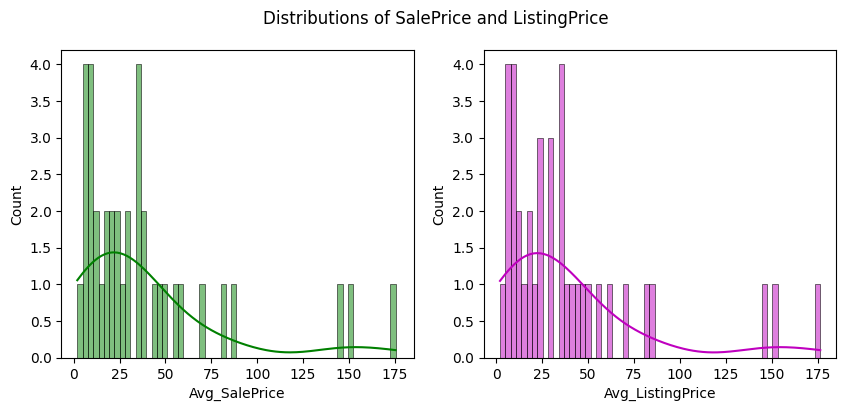

In [113]:
lp= walmartdf.groupBy('MainCategory').agg(fxn.round(fxn.mean("List Price"),2).alias("Avg_ListingPrice"),
                                         fxn.round(fxn.mean("Sale Price"),2).alias("Avg_SalePrice"))
datalp = lp.toPandas()

import seaborn as sns
f, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

sns.histplot(data=datalp,bins=60, kde=True,x="Avg_SalePrice",ax=axes[0],color="g",)
sns.histplot(data=datalp,bins=60, kde=True,x="Avg_ListingPrice",ax=axes[1],color="m",)
plt.suptitle('Distributions of SalePrice and ListingPrice')

### Conclusions:
   1. The distribution of sale price is skewed to the right, which means that there are more sales at lower prices than at higher prices.
   2. The distribution of listing price is also skewed to the right, but not as much as the sale price. This suggests that sellers are generally asking for higher prices than they are willing to accept.
   3. The mean sale price is lower than the mean listing price, which is consistent with the fact that the distribution of sale price is skewed to the right.

Main actegories that are having ZERO average discount
+--------------------+----------------+-------------+--------------+
|        MainCategory|Avg_ListingPrice|Avg_SalePrice|Mean_%Discount|
+--------------------+----------------+-------------+--------------+
|            Jewelry |             8.0|          8.0|          0.0%|
|    Home Improvement|            82.0|         82.0|          0.0%|
|        Electronics |           50.65|        50.65|          0.0%|
|            Feature |             8.4|          8.4|          0.0%|
|Arts Crafts & Sew...|            5.75|         5.75|          0.0%|
|              Music |            13.0|         13.0|          0.0%|
|        Auto & Tires|             5.0|          5.0|          0.0%|
|       Collectibles |            86.0|         86.0|          0.0%|
|    Office Supplies |             8.0|          8.0|          0.0%|
|Industrial & Scie...|             5.0|          5.0|          0.0%|
|       Shop by Brand|             8.5|          

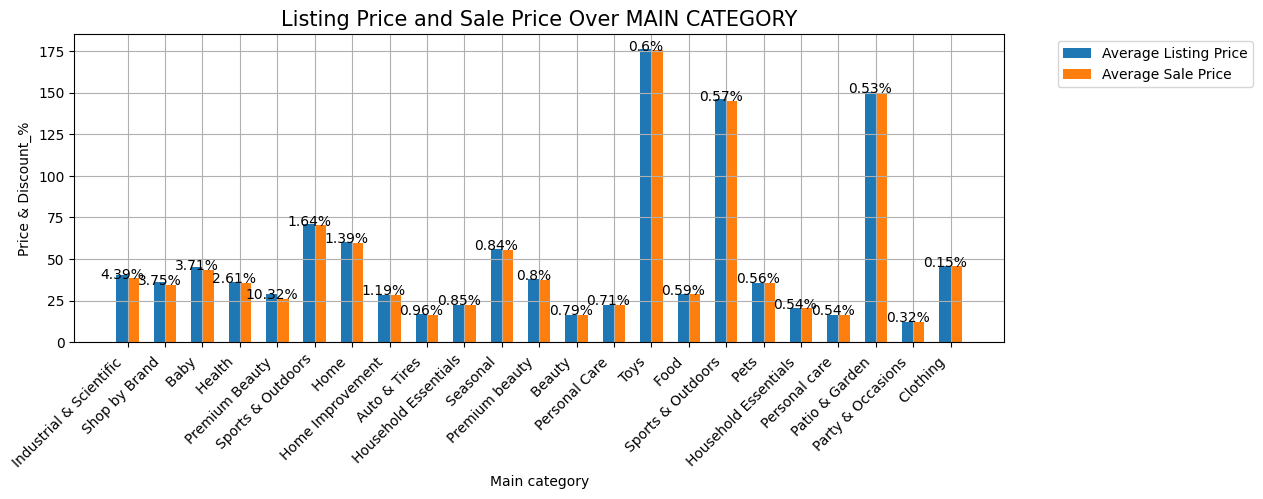

In [116]:
import matplotlib.pyplot as plt
import numpy as np

pricedf = walmartdf.groupBy("MainCategory").agg(
    fxn.round(fxn.mean("List Price"),2).alias("Avg_ListingPrice"),
    fxn.round(fxn.mean("Sale Price"),2).alias("Avg_SalePrice"))

pricedf = pricedf.withColumn(
    "Mean_%Discount",
    fxn.concat(fxn.round(((1 - (pricedf["Avg_SalePrice"] / pricedf["Avg_ListingPrice"])) * 100), 2),fxn.lit('%'))
)
pricedf = pricedf.orderBy('Mean_%Discount',ascending = False)


pricedf_pd = pricedf.filter(pricedf['Mean_%Discount']!='0.0%').toPandas()
plt.figure(figsize=(12, 4))

# Plot List Price and Sale Price for each Main Category
bar_width = 0.3
bar_positions = range(len(pricedf_pd))

plt.bar(bar_positions, pricedf_pd["Avg_ListingPrice"], width=bar_width, label="Average Listing Price")
plt.bar([pos + bar_width for pos in bar_positions], pricedf_pd["Avg_SalePrice"], width=bar_width,
        label="Average Sale Price")

for i, value in enumerate(pricedf_pd["Mean_%Discount"]):
    plt.text(i, pricedf_pd["Avg_SalePrice"].iloc[i], f"{value}", ha='center')

plt.xticks([pos + bar_width/2 for pos in bar_positions], pricedf_pd["MainCategory"])
plt.title("Listing Price and Sale Price Over MAIN CATEGORY",fontsize=15)
plt.xlabel("Main category")
plt.ylabel("Price & Discount_%")
plt.xticks(rotation=45, ha='right')
plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

print("Main actegories that are having ZERO average discount")

pricedf.filter(pricedf['Mean_%Discount']=='0.0%').show()


#### **Conclusions from the above Plot**
   1.   Overall, for the main categories displayed in plot shows that, the average listing price is higher than the average sale price for all main categories. This suggests that sellers are generally willing to negotiate on price.
   2. The largest discount is for the "Premium Beauty" category, followed by "Industrial & Scientific" and "Baby and Health" products. This suggests that these categories are more price-sensitive than others.
   3. The smallest discount is for the "Clothing" category. This suggests that, it is very less price-sensitive category in walmart than other main categories.
   4. Main categories like "Stationery, Mobile electronics, and jewelery, and others" are having Zero discounts in the Walmart









In [117]:

correlation_value = walmartdf.select(fxn.corr('List Price', 'Sale price')).collect()[0][0]

print(f"Correlation between 'ListPrice' and 'SalePrice': {correlation_value}")


Correlation between 'ListPrice' and 'SalePrice': 0.9996974061383688


In [118]:
import plotly.graph_objects as go
import pandas as pd

# Assuming you have a DataFrame named 'PlotData'
# Replace 'PlotData' with your actual DataFrame
PlotData = walmartdf.toPandas()
# Calculate the correlation matrix
correlation_matrix = PlotData[['List Price', 'Sale Price']].corr()

# Create a Plotly Heatmap with text annotations
fig =px.imshow(correlation_matrix,text_auto=True,color_continuous_scale='Tealgrn')

fig.update_xaxes(side="bottom")

# Customize the layout
fig.update_layout(
    title='Correlation between Price of SALE and LISTING',
    width = 500, height = 500,
    yaxis=dict(tickmode='array', tickvals=list(range(len(correlation_matrix.columns))),
               ticktext=correlation_matrix.columns)
)

fig.show()


#### **Conclusions from the above Plot**
   1.  The attributes, ListPrice and SalePrice are highly correlated as there are derived by applying dicount on the LISTING PRICE of products. From the plot one can deduct that, the strong POSITIVE correlation is present between these two variables.

# MainCategory Analysis

In [119]:
import plotly.express as px

# Create a bar plot with counts displayed on each bar
fig = px.bar(walmartdf.toPandas()['MainCategory'].value_counts().reset_index(),
             x='index',
             y='MainCategory',
             text='MainCategory', color='index',
             labels={'index': 'Main Category', 'Main_Category': 'Count'})

fig.update_traces(texttemplate='%{text}', textposition='outside')

fig.update_layout(title='Distribution of Main Categories',
                  xaxis_title='Main Category',
                  yaxis_title='Count',
                  xaxis={'categoryorder': 'total descending'})


fig.show()


In [120]:
import plotly.express as px
walmartdf = walmartdf.withColumn("MainCategory", fxn.trim(fxn.col("MainCategory")))

availabitydf = walmartdf.groupBy("MainCategory",'Available').agg(
    fxn.count('MainCategory').alias("Count"),
    fxn.round(fxn.mean("List Price"),2).alias("Avg_ListingPrice"),
    fxn.round(fxn.mean("Sale Price"),2).alias("Avg_SalePrice"))
availabitydf=availabitydf.withColumn(
    "Mean_%Discount",
    fxn.concat(fxn.round(((1 - (availabitydf["Avg_SalePrice"] / availabitydf["Avg_ListingPrice"])) * 100), 2),fxn.lit('%'))
)
availabitydf = availabitydf.filter((availabitydf['Mean_%Discount']!='0.0%') ).\
orderBy('Mean_%Discount',ascending=False)
# availabitydf.show(100,False)
your_df = availabitydf.toPandas()

your_df['Mean_%Discount'] = your_df['Mean_%Discount'].str.rstrip('%').astype('float')

fig = px.bar(your_df, x='MainCategory', y='Avg_SalePrice', color='Mean_%Discount',
             labels={'value': 'Price'},
             title='Product Availabilty by MainCategory with Mean Percentage Discount',
             height=600,
             facet_col="Available",
             category_orders={"Available": ["TRUE", "FALSE"]},text='Count',)


fig.update_layout(
    legend=dict(title='Mean Percentage Discount'),
    barmode='group',
    yaxis_title='Price',
    xaxis_title='Main Category',
    margin=dict(l=20, r=20, t=70, b=20),
)

# Show the plot
fig.show()


# Brand Analysis

In [121]:
import plotly.subplots as sp
import plotly.graph_objects as go
import pandas as pd


bddf= walmartdf.groupBy("Brand","Available").count().orderBy('count',ascending=False)
bddf_true = bddf
# bddf_true.show(10, False)
bddf_false = bddf.filter((bddf['Available']== 'FALSE'))
# bddf_false.show(10)
# Create subplots with 1 row and 2 columns
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=("Top 15 brands available in Walmart Stores", "Top 15 brands OUT OF STOCK"))

# Plotly Bar Graph for Top 15 brands available in Walmart Stores
trace1 = go.Bar(x=bddf_true.limit(10).toPandas()["Brand"], y=bddf_true.limit(15).toPandas()["count"],
                marker=dict(color='skyblue'),text=bddf_true.limit(15).toPandas()['count'],textposition='outside')
fig.add_trace(trace1, row=1, col=1)

# Plotly Bar Graph for Top 15 brands OUT OF STOCK
trace2 = go.Bar(x=bddf_false.limit(10).toPandas()["Brand"], y=bddf_false.limit(15).toPandas()["count"], marker=dict(color='seagreen'),
                text=bddf_false.limit(15).toPandas()['count'],textposition='outside')
fig.add_trace(trace2, row=1, col=2)

# Update layout
fig.update_layout(title_text="Top 15 brands availability in Walmart Stores", showlegend=False)

# Update axes titles
fig.update_xaxes(title_text="Brand", row=1, col=1)
fig.update_yaxes(title_text="Count", row=1, col=1)
fig.update_xaxes(title_text="Brand", row=1, col=2)
fig.update_yaxes(title_text="Count", row=1, col=2)

# Adjust layout
fig.update_layout(width=1000, height=500, showlegend=False,xaxis_tickangle=-45)
fig.update_traces(texttemplate='%{text}', textposition='outside')
# Display the plot
fig.show()


In [122]:
bddf = walmartdf.groupBy("Brand",'Available').agg(
    fxn.count('Brand').alias("Count"),
    fxn.round(fxn.mean("List Price"),2).alias("Avg_ListingPrice"),
    fxn.round(fxn.mean("Sale Price"),2).alias("Avg_SalePrice"))
bddf=bddf.withColumn(
    "Discount%_OnBrand",
    fxn.concat(fxn.round(((1 - (bddf["Avg_SalePrice"] / bddf["Avg_ListingPrice"])) * 100), 2))
)

bddf.show(10)
bddf=bddf.withColumn("Discount%_OnBrand",fxn.col("Discount%_OnBrand").cast(FloatType()))

bddf = bddf.filter((bddf['Discount%_OnBrand']>0 )& (bddf['Available']== 'TRUE')).\
orderBy('Avg_SalePrice','Discount%_OnBrand',ascending =[False,False])
bddf.show(15,truncate=False)

+--------------------+---------+-----+----------------+-------------+-----------------+
|               Brand|Available|Count|Avg_ListingPrice|Avg_SalePrice|Discount%_OnBrand|
+--------------------+---------+-----+----------------+-------------+-----------------+
|        Alka-Seltzer|     TRUE|    5|            12.4|         12.4|              0.0|
|Skywalker Trampol...|     TRUE|   13|          170.38|       163.54|             4.01|
|         Wild Planet|     TRUE|    5|            61.2|         58.6|             4.25|
|         Jelly Belly|     TRUE|    7|           21.43|        21.43|              0.0|
|            Rawlings|     TRUE|   79|           81.38|        79.84|             1.89|
|            Rawlings|    FALSE|    3|           10.67|        10.67|              0.0|
|            Barbasol|     TRUE|    5|            24.4|         24.4|              0.0|
|  Treadmillpartszone|     TRUE|   17|           18.29|        18.29|              0.0|
|    Growing Naturals|     TRUE|

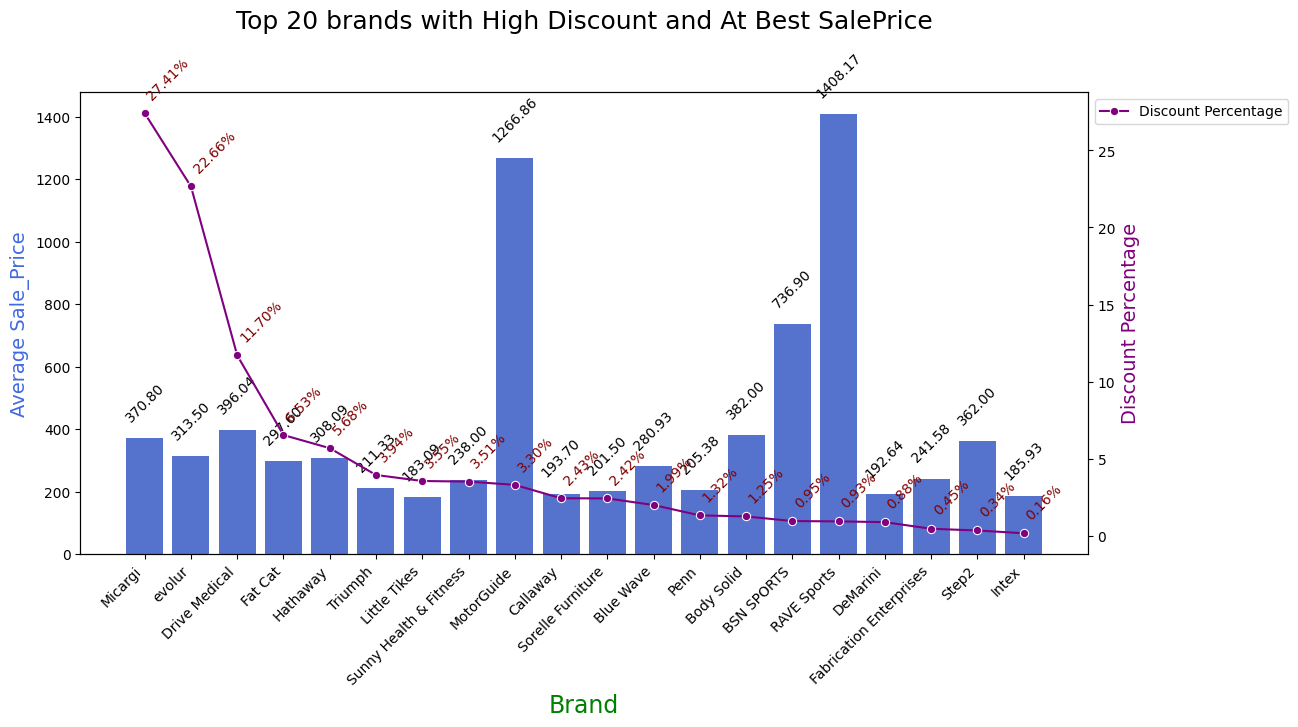

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt

data_to_plot = bddf.limit(20).orderBy('Discount%_OnBrand', ascending=False).toPandas()

# Set the figure size
plt.figure(figsize=(13, 6))

# Create a grouped bar plot for Avg Sale Price
ax1 = sns.barplot(
    data=data_to_plot,
    x="Brand",
    y="Avg_SalePrice",
    color="royalblue",  # Color for Avg Sale Price
    label="Avg Sale Price"
)
ax1.set_ylabel('Average Sale_Price', color="royalblue",fontsize=14)
ax1.set_xlabel('Brand', color="green",fontsize=17)

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")

# Add values on top of the Avg Sale Price bars with rotation
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', xytext=(0, 10), textcoords='offset points', rotation=45)

# Add another line for Discount Percentage
ax2 = plt.twinx()
sns.lineplot(
    data=data_to_plot,
    x="Brand",
    y="Discount%_OnBrand",
    color="purple",
    marker="o",
    ax=ax2,
    label="Discount Percentage"
)

# Annotate all values on top of the Discount Percentage line
for line in ax2.lines:
    for x, y in zip(line.get_xdata(), line.get_ydata()):
        ax2.annotate(f'{y:.2f}%', (x, y),
                     xytext=(0, 10), textcoords='offset points', color="maroon", rotation=45)

# Set plot title and labels
plt.title('Top 20 brands with High Discount and At Best SalePrice\n\n',fontsize=18)
ax2.set_ylabel('Discount Percentage', color="purple",fontsize=14)
# plt.x
# Show the legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()


In [124]:
from pyspark.sql.window import Window

topbrnd = walmartdf.groupby('Brand','state_name').agg(fxn.count('Brand').alias('count'))

window_spec = Window.partitionBy('state_name').orderBy(fxn.desc('count'))

topbrnd_state = topbrnd.withColumn('row_number', fxn.row_number().over(window_spec))

# Show the result
topbrnd_state= topbrnd_state.orderBy('state_name', 'row_number', ascending=[False, True])
topbrnd_state = topbrnd_state.filter(fxn.col('row_number')==1).orderBy('Brand')
topbrnd_state= topbrnd_state.drop('row_number')
# topbrnd_state.show(100)

import plotly.express as px
fig = px.bar(topbrnd_state.toPandas(), x='state_name', y='count', color='Brand',
             title='Top Brand for each state in US across the Walmart stores',
             labels={'count': 'Count', 'Brand': 'Brand'},text=topbrnd_state.toPandas()['Brand'],
             category_orders={'state_name': topbrnd_state.toPandas()['state_name'].unique()})



fig.update_layout(xaxis_tickangle=-45)
fig.show()


In [125]:
walmartdf.show()

+--------------------+--------------------+--------------------+----------+----------+---------+----+-----+--------------------+----------+--------------+-----------------+
|               Brand|        Product Name|         Description|List Price|Sale Price|Available|Year|Month|        Product_Type|PostalCode|    state_name|     MainCategory|
+--------------------+--------------------+--------------------+----------+----------+---------+----+-----+--------------------+----------+--------------+-----------------+
|        Alka-Seltzer|Alka-Seltzer Orig...|We aim to show yo...|         9|         9|     TRUE|2020|    3| Alka-Seltzer Eff...|     30274|       Georgia|           Health|
|Skywalker Trampol...|Skywalker Trampol...| We aim to show y...|        29|        29|     TRUE|2020|    1| Skywalker Trampo...|     37209|     Tennessee|Sports & Outdoors|
|Skywalker Trampol...|Skywalker Trampol...| We aim to show y...|        89|        77|     TRUE|2020|    1|    Trampoline Parts|     76

## Products availabilty by State

In [126]:
colors = {'TRUE': 'skyblue', 'FALSE': 'red'}


plot = walmartdf.groupby('state_name','Available').agg(fxn.count('Brand').alias('count')).toPandas()
# plot
fig = px.bar(plot, x="state_name", y='count', color="Available",color_discrete_map=colors ,title="Product availability by States")
fig.show()

## Brand count in each state in USA

In [127]:
dsa = walmartdf.groupby('state_name').agg(fxn.count('Brand').alias('count'))
dsa.show()

+--------------------+-----+
|          state_name|count|
+--------------------+-----+
|                Utah|  194|
|              Hawaii|   29|
|           Minnesota|  288|
|                Ohio|  576|
|            Arkansas|  329|
|              Oregon|  173|
|               Texas| 1644|
|        North Dakota|   54|
|        Pennsylvania|  506|
|         Connecticut|  117|
|            Nebraska|  162|
|             Vermont|   28|
|              Nevada|  162|
|          Washington|  246|
|            Illinois|  637|
|            Oklahoma|  361|
|District of Columbia|   10|
|            Delaware|   42|
|              Alaska|   43|
|          New Mexico|  153|
+--------------------+-----+
only showing top 20 rows



In [128]:
import geopandas as gpd
import plotly.express as px

dsa = walmartdf.groupby('state_name').agg(fxn.count('Brand').alias('count'))

fig = px.scatter(dsa.toPandas(), x='state_name', y='count', size='count', color='state_name',
                 hover_name='state_name', size_max=50,text='count',
                 labels={'count': 'Count'},
                 title='Number of Brands by State')


# Show the plot
fig.show()

## ML techniques


In [129]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoder, VectorAssembler
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="Brand", outputCol="Brandidx")
X = indexer.fit(walmartdf).transform(walmartdf)

# OneHotEncoder
encoder = OneHotEncoder(inputCol="Brandidx", outputCol="BrandVec")
X_encoded = encoder.fit(X).transform(X)

X_encoded.show()

+--------------------+--------------------+--------------------+----------+----------+---------+----+-----+--------------------+----------+--------------+-----------------+--------+-------------------+
|               Brand|        Product Name|         Description|List Price|Sale Price|Available|Year|Month|        Product_Type|PostalCode|    state_name|     MainCategory|Brandidx|           BrandVec|
+--------------------+--------------------+--------------------+----------+----------+---------+----+-----+--------------------+----------+--------------+-----------------+--------+-------------------+
|        Alka-Seltzer|Alka-Seltzer Orig...|We aim to show yo...|         9|         9|     TRUE|2020|    3| Alka-Seltzer Eff...|     30274|       Georgia|           Health|   906.0| (1582,[906],[1.0])|
|Skywalker Trampol...|Skywalker Trampol...| We aim to show y...|        29|        29|     TRUE|2020|    1| Skywalker Trampo...|     37209|     Tennessee|Sports & Outdoors|   281.0| (1582,[281

In [130]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt


selected_features = ['BrandVec', 'List Price']
assembler = VectorAssembler(inputCols=selected_features, outputCol='features')
df_assembled = assembler.transform(X_encoded)

# Split the data into training and test sets
train_df, test_df = df_assembled.randomSplit([0.8, 0.2], seed=42)

# Create a Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='Sale Price')
print(lr)
# Fit the model on the training data
lr_model = lr.fit(train_df)
print(lr_model)
# Make predictions on the test data
predictions = lr_model.transform(test_df)

evaluator = RegressionEvaluator(labelCol='Sale Price', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Other evaluation metrics
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")


LinearRegression_6569988b94f8
LinearRegressionModel: uid=LinearRegression_6569988b94f8, numFeatures=1583
Root Mean Squared Error (RMSE): 8.887611584141881
Mean Absolute Error (MAE): 1.4193426422758058
R-squared (R2): 0.9994465317606848


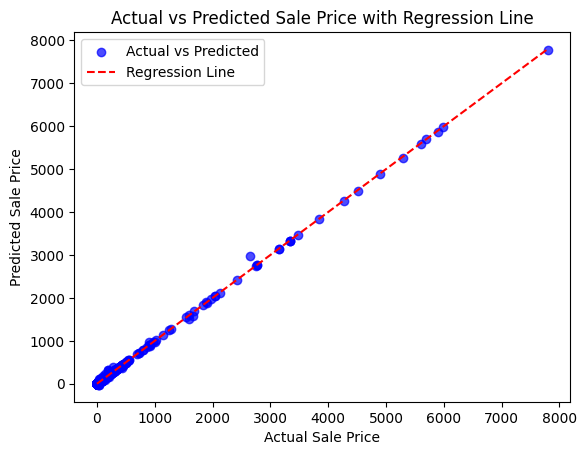

In [131]:
predictions_pd = predictions.select('Sale Price', 'prediction').toPandas()

# Scatter plot for actual values
plt.scatter(predictions_pd['Sale Price'], predictions_pd['prediction'], c='blue', label='Actual vs Predicted', alpha=0.7)

# Regression line
regression_line = [min(predictions_pd['Sale Price']), max(predictions_pd['Sale Price'])]
plt.plot(regression_line, regression_line, linestyle='--', color='red', label='Regression Line')

# Labeling and title
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs Predicted Sale Price with Regression Line')
plt.legend()
plt.show()

In [132]:
predictions.select('Brand','List Price',  'Sale Price','prediction').sample(False, 0.1).limit(5).show(truncate=False)

+--------------+----------+----------+------------------+
|Brand         |List Price|Sale Price|prediction        |
+--------------+----------+----------+------------------+
|ACTION        |14        |14        |14.00939819198588 |
|ACTION        |43        |43        |42.9027491437983  |
|Airhead       |22        |22        |22.394659833738157|
|BAND-AID Brand|5         |5         |4.33210748220474  |
|Baden         |45        |45        |44.92544596317922 |
+--------------+----------+----------+------------------+



In [133]:
walmartdf.show()

+--------------------+--------------------+--------------------+----------+----------+---------+----+-----+--------------------+----------+--------------+-----------------+
|               Brand|        Product Name|         Description|List Price|Sale Price|Available|Year|Month|        Product_Type|PostalCode|    state_name|     MainCategory|
+--------------------+--------------------+--------------------+----------+----------+---------+----+-----+--------------------+----------+--------------+-----------------+
|        Alka-Seltzer|Alka-Seltzer Orig...|We aim to show yo...|         9|         9|     TRUE|2020|    3| Alka-Seltzer Eff...|     30274|       Georgia|           Health|
|Skywalker Trampol...|Skywalker Trampol...| We aim to show y...|        29|        29|     TRUE|2020|    1| Skywalker Trampo...|     37209|     Tennessee|Sports & Outdoors|
|Skywalker Trampol...|Skywalker Trampol...| We aim to show y...|        89|        77|     TRUE|2020|    1|    Trampoline Parts|     76

## 2 GBT Regressor

---



In [134]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler

gbt = GBTRegressor(featuresCol='features', labelCol='Sale Price', maxIter=10)
gbt_model = gbt.fit(train_df)

# Make predictions on the test data
predictions_gbt = gbt_model.transform(test_df)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol='Sale Price', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions_gbt)
print(f"Root Mean Squared Error (RMSE) for GBT: {rmse}")

Root Mean Squared Error (RMSE) for GBT: 216.50206898530325


In [135]:
mae = evaluator.evaluate(predictions_gbt, {evaluator.metricName: "mae"})
r2 = evaluator.evaluate(predictions_gbt, {evaluator.metricName: "r2"})

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Mean Absolute Error (MAE): 28.68089370227825
R-squared (R2): 0.671567086180496


## Topic Modelling

In [136]:
walmartdf.show(10)

+--------------------+--------------------+--------------------+----------+----------+---------+----+-----+--------------------+----------+--------------+-----------------+
|               Brand|        Product Name|         Description|List Price|Sale Price|Available|Year|Month|        Product_Type|PostalCode|    state_name|     MainCategory|
+--------------------+--------------------+--------------------+----------+----------+---------+----+-----+--------------------+----------+--------------+-----------------+
|        Alka-Seltzer|Alka-Seltzer Orig...|We aim to show yo...|         9|         9|     TRUE|2020|    3| Alka-Seltzer Eff...|     30274|       Georgia|           Health|
|Skywalker Trampol...|Skywalker Trampol...| We aim to show y...|        29|        29|     TRUE|2020|    1| Skywalker Trampo...|     37209|     Tennessee|Sports & Outdoors|
|Skywalker Trampol...|Skywalker Trampol...| We aim to show y...|        89|        77|     TRUE|2020|    1|    Trampoline Parts|     76

In [137]:
import re

desc_wlmt = walmartdf.select('Description')
desc_wlmt=desc_wlmt.withColumn("OnlyDescription", fxn.trim(fxn.split("Description", "\\|")[1]))
desc_wlmt=desc_wlmt.drop('Description')

def process_text(text):

    # text= fxn.trim(text)
    # Remove punctuation
    text_withoutSpChar = re.sub(r'[^A-Za-z\s]', '', text)
    text_noSpcs = re.sub(r'\s+', ' ', text_withoutSpChar).strip()
    text_Word3 = re.sub(r'\b\w{3}\b', '', text_noSpcs)


    # Convert to lowercase
    text = text_Word3.lower()
    return text

# Create a UDF from the function
process_text_udf = fxn.udf(process_text, StringType())

# Apply the UDF to the DataFrame
desc_wlmt = desc_wlmt.withColumn("Description_processed", process_text_udf("OnlyDescription"))

# Show the processed DataFrame
desc_wlmt.show(truncate= False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [138]:
!pip install pandas==1.5.3

In [139]:
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol="Description_processed", outputCol="tokens")
desc_wlmt = tokenizer.transform(desc_wlmt)

# Remove stop words
remover = StopWordsRemover(inputCol="tokens", outputCol="wrds_nostop")
desc_wlmt = remover.transform(desc_wlmt)

# Select relevant columns
# desc_wlmt = desc_wlmt.select("Description_processed", "DescNoStpwrds")
desc_wlmt = desc_wlmt.withColumn("DescNoStpwrds", fxn.concat_ws(" ", "wrds_nostop"))
desc_wlmt.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [140]:
import pandas as pd
from wordcloud import WordCloud
import plotly.express as px

# # Sample DataFrame
# data = {'TextColumn': ["This is a sample text with some words.", "Create a word cloud with Plotly."]}
# df = pd.DataFrame(data)
pd_descwlmt = desc_wlmt.toPandas()
# Concatenate text from all rows
# ','.join(list(pd_descwlmt['DescNoStpwrds'].values))
all_text = ' '.join(pd_descwlmt['DescNoStpwrds'])

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Create a Plotly figure
fig = px.imshow(wordcloud, binary_string=True, width=800, height=400)
fig.update_layout(title_text='Word Cloud', title_x=0.5)

# Show the plot
fig.show()


In [141]:
!pip install pyldavis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 26.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicor

In [142]:
%%time
from gensim import corpora, models
import pandas as pd
import pyLDAvis.gensim
import multiprocessing
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

data = pd_descwlmt['DescNoStpwrds']
df = pd.DataFrame(data)

# Tokenize the text
tokenized_text = [text.split() for text in df['DescNoStpwrds']]

# Create a dictionary from the tokenized text
dictionary = corpora.Dictionary(tokenized_text)

# Create a document-term matrix
doc_term_matrix = [dictionary.doc2bow(tokens) for tokens in tokenized_text]
print(doc_term_matrix[1])


[(10, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2), (30, 1), (31, 2), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 4), (41, 2), (42, 4), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 2), (49, 1), (50, 1), (51, 5), (52, 3), (53, 1), (54, 1), (55, 2), (56, 1), (57, 1), (58, 1), (59, 8), (60, 5), (61, 1), (62, 1), (63, 2), (64, 1), (65, 1)]
CPU times: user 5.24 s, sys: 194 ms, total: 5.44 s
Wall time: 12.1 s


In [143]:
%%time

import gensim
from pprint import pprint
# number of topics
num_topics = 15
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=doc_term_matrix,
                                       id2word=dictionary,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[doc_term_matrix]

[(0,
  '0.017*"x" + 0.011*"light" + 0.009*"power" + 0.008*"battery" + 0.007*"v" + '
  '0.006*"w" + 0.005*"size" + 0.005*"easy" + 0.004*"time" + 0.004*"color"'),
 (1,
  '0.016*"x" + 0.010*"fishing" + 0.007*"easy" + 0.005*"design" + 0.005*"safe" '
  '+ 0.004*"stroller" + 0.004*"foam" + 0.004*"baby" + 0.003*"size" + '
  '0.003*"head"'),
 (2,
  '0.010*"teeth" + 0.006*"skin" + 0.005*"body" + 0.005*"water" + 0.005*"size" '
  '+ 0.005*"hair" + 0.004*"clean" + 0.004*"natural" + 0.004*"soft" + '
  '0.004*"light"'),
 (3,
  '0.013*"crib" + 0.012*"bulb" + 0.007*"caviar" + 0.007*"product" + '
  '0.007*"sheet" + 0.006*"hair" + 0.005*"white" + 0.005*"baby" + 0.005*"free" '
  '+ 0.005*"light"'),
 (4,
  '0.021*"hair" + 0.015*"skin" + 0.008*"baby" + 0.005*"oz" + 0.005*"color" + '
  '0.005*"x" + 0.004*"free" + 0.004*"soft" + 0.004*"natural" + 0.004*"body"'),
 (5,
  '0.009*"x" + 0.007*"features" + 0.007*"easy" + 0.006*"design" + '
  '0.006*"color" + 0.006*"material" + 0.005*"hair" + 0.005*"comfortable" + 

In [144]:
!pip install pandas==1.5.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 76.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.3
    Uninstalling pandas-2.1.3:
      Successfully uninstalled pandas-2.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.


In [145]:
%%time
import pyLDAvis.gensim
import pickle
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()

if __name__ == '__main__':
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)

LDAvis_prepared

CPU times: user 15.3 s, sys: 233 ms, total: 15.5 s
Wall time: 43.9 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.099337 -0.062983       1        1  14.820182
8     -0.148572 -0.036377       2        1  12.785939
7      0.220643  0.008955       3        1  10.445518
6     -0.113012  0.028944       4        1   7.026951
5     -0.050368 -0.020847       5        1   5.886567
13    -0.073479  0.108540       6        1   5.677188
14     0.047026 -0.056176       7        1   5.402375
4      0.066298  0.033681       8        1   5.336256
10     0.092469 -0.088570       9        1   5.229411
11     0.004237 -0.104695      10        1   5.123605
0     -0.090219  0.097445      11        1   5.105076
9      0.072346  0.068549      12        1   4.659218
2      0.076233  0.036275      13        1   4.603333
1     -0.066327 -0.058099      14        1   4.008697
3      0.062062  0.045358      15        1   3.889682, topic_info=       Term          Freq         Total Category  logprob  loglift
65        x  14624.000000  14624.000000  Default  30.0000  30.0000
570    hair   2933.000000   2933.000000  Default  29.0000  29.0000
454   light   4408.000000   4408.000000  Default  28.0000  28.0000
1056   baby   4106.000000   4106.000000  Default  27.0000  27.0000
1158     cm   4463.000000   4463.000000  Default  26.0000  26.0000
...     ...           ...           ...      ...      ...      ...
3765  teeth    173.928239   1168.409368  Topic15  -5.7291   1.3421
2338   type    186.753304   2051.049513  Topic15  -5.6580   0.8505
363   color    213.183583   6577.530010  Topic15  -5.5256  -0.1824
428    pack    182.230108   2503.401743  Topic15  -5.6825   0.6267
65        x    174.854166  14624.718744  Topic15  -5.7238  -1.1797

[1307 rows x 6 columns], token_table=       Topic      Freq               Term
term                                     
20414     10  0.875409  abrasionresistant
10506      7  0.886649       absorbencies
8413      14  0.919116            academy
22840      7  0.864320        accumulated
653        1  0.013002           accurate
...      ...       ...                ...
332       11  0.029553              youre
332       12  0.028210              youre
332       13  0.037613              youre
332       14  0.032239              youre
332       15  0.009403              youre

[7369 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 9, 8, 7, 6, 14, 15, 5, 11, 12, 1, 10, 3, 2, 4])

In [146]:
%%time
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_text, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.4261186666989074
CPU times: user 14 s, sys: 56.3 ms, total: 14 s
Wall time: 14.2 s


Computing Coherence:   0%|          | 0/11 [17:45<?, ?it/s]


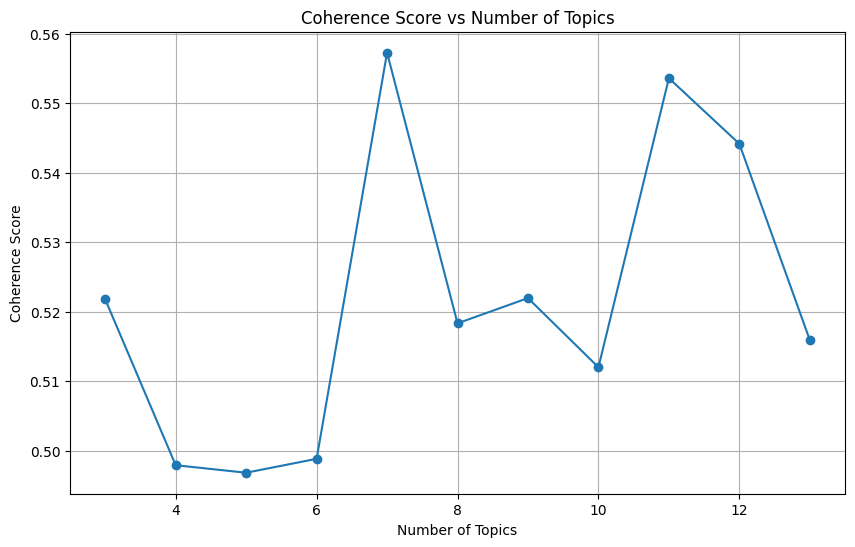

Optimal Number of Topics: 7
CPU times: user 7.8 s, sys: 953 ms, total: 8.76 s
Wall time: 17min 48s


In [147]:
%%time

from tqdm import tqdm
import numpy as np
from multiprocessing import Pool
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

# Assuming 'texts', 'id2word', and 'corpus_gensim' are defined
num_topics_range = range(3, 14)
id2word = dictionary
tokenized_text = [text.split() for text in df['DescNoStpwrds']]
corpus_gensim = [id2word.doc2bow(text) for text in tokenized_text]
def compute_coherence(num_topics):
    lda_model = LdaModel(corpus_gensim, id2word=dictionary, num_topics=num_topics, passes=10, iterations=50)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_text, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return num_topics, coherence_lda

# Use multiprocessing to parallelize the computation
# with Pool() as pool:
#     results = pool.map(compute_coherence, num_topics_range)
with Pool() as pool, tqdm(total=len(num_topics_range), desc="Computing Coherence") as pbar:
    results = list(tqdm(pool.imap(compute_coherence, num_topics_range), total=len(num_topics_range)))

# Extract results
topics, coherence_scores = zip(*results)

# Find the optimal number of topics
optimal_num_topics = topics[np.argmax(coherence_scores)]

# Visualize coherence scores vs number of topics
plt.figure(figsize=(10, 6))
plt.plot(topics, coherence_scores, marker='o')
plt.title('Coherence Score vs Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.grid(True)
plt.show()

print(f"Optimal Number of Topics: {optimal_num_topics}")


In [148]:
%%time
import gensim
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=doc_term_matrix,
                                       id2word=dictionary,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[doc_term_matrix]

[(0,
  '0.021*"x" + 0.010*"easy" + 0.010*"material" + 0.009*"cm" + 0.008*"size" + '
  '0.007*"durable" + 0.007*"weight" + 0.007*"color" + 0.006*"package" + '
  '0.006*"features"'),
 (1,
  '0.011*"skin" + 0.008*"organic" + 0.008*"oz" + 0.007*"bulb" + 0.006*"made" + '
  '0.006*"body" + 0.005*"pack" + 0.005*"bath" + 0.005*"natural" + '
  '0.004*"ingredients"'),
 (2,
  '0.005*"easy" + 0.005*"oz" + 0.004*"comfort" + 0.004*"great" + '
  '0.004*"products" + 0.004*"size" + 0.004*"bags" + 0.004*"fresh" + '
  '0.004*"coffee" + 0.004*"natural"'),
 (3,
  '0.006*"x" + 0.006*"health" + 0.005*"help" + 0.005*"water" + 0.005*"free" + '
  '0.005*"size" + 0.005*"natural" + 0.005*"product" + 0.005*"weight" + '
  '0.004*"support"'),
 (4,
  '0.009*"toilet" + 0.008*"seat" + 0.007*"size" + 0.007*"design" + '
  '0.007*"material" + 0.007*"comfort" + 0.006*"color" + 0.005*"shoes" + '
  '0.005*"provides" + 0.004*"potty"'),
 (5,
  '0.010*"x" + 0.007*"battery" + 0.006*"easy" + 0.006*"bike" + 0.006*"power" + '
  '0.

In [149]:
%%time
import pyLDAvis.gensim
import pickle
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()

if __name__ == '__main__':
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)

LDAvis_prepared

CPU times: user 9.99 s, sys: 270 ms, total: 10.3 s
Wall time: 17.2 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.115908  0.054427       1        1  22.517826
6      0.044178  0.001909       2        1  12.601709
1     -0.171755 -0.014401       3        1  11.527533
3     -0.107405 -0.003971       4        1   9.365521
2     -0.014356 -0.002100       5        1   8.845885
7     -0.004469  0.109580       6        1   8.667766
5      0.054818 -0.071463       7        1   8.607995
4      0.102414 -0.004163       8        1   7.771516
9     -0.044146  0.039981       9        1   7.323755
8      0.024813 -0.109799      10        1   2.770493, topic_info=          Term          Freq         Total Category  logprob  loglift
65           x  14487.000000  14487.000000  Default  30.0000  30.0000
556    battery   1744.000000   1744.000000  Default  29.0000  29.0000
1075      skin   3040.000000   3040.000000  Default  28.0000  28.0000
1073      seat   2036.000000   2036.000000  Default  27.0000  27.0000
7145    toilet   1211.000000   1211.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
1475   package    116.158572   4659.313101  Topic10  -5.7935  -0.1055
363      color    115.373042   6609.005259  Topic10  -5.8003  -0.4619
316   material    114.678237   6279.213436  Topic10  -5.8064  -0.4167
1693     power    102.375824   2231.846441  Topic10  -5.9198   0.5042
278       time     96.085629   3260.811231  Topic10  -5.9832   0.0617

[924 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
17445      4  0.913994    abbott
17445      7  0.031517    abbott
17004      2  0.044319      acai
17004      4  0.901151      acai
17004      9  0.044319      acai
...      ...       ...       ...
3329       7  0.010573  zippered
3329       8  0.031720  zippered
3329       9  0.021146  zippered
3329      10  0.010573  zippered
8537       8  0.913230     zonal

[4133 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 2, 4, 3, 8, 6, 5, 10, 9])

In [150]:
for topic_id, topic in lda_model.print_topics():
    print(f"Topic ID: {topic_id}")
    print(f"Words: {topic}")
    print()

Topic ID: 0
Words: 0.021*"x" + 0.010*"easy" + 0.010*"material" + 0.009*"cm" + 0.008*"size" + 0.007*"durable" + 0.007*"weight" + 0.007*"color" + 0.006*"package" + 0.006*"features"

Topic ID: 1
Words: 0.011*"skin" + 0.008*"organic" + 0.008*"oz" + 0.007*"bulb" + 0.006*"made" + 0.006*"body" + 0.005*"pack" + 0.005*"bath" + 0.005*"natural" + 0.004*"ingredients"

Topic ID: 2
Words: 0.005*"easy" + 0.005*"oz" + 0.004*"comfort" + 0.004*"great" + 0.004*"products" + 0.004*"size" + 0.004*"bags" + 0.004*"fresh" + 0.004*"coffee" + 0.004*"natural"

Topic ID: 3
Words: 0.006*"x" + 0.006*"health" + 0.005*"help" + 0.005*"water" + 0.005*"free" + 0.005*"size" + 0.005*"natural" + 0.005*"product" + 0.005*"weight" + 0.004*"support"

Topic ID: 4
Words: 0.009*"toilet" + 0.008*"seat" + 0.007*"size" + 0.007*"design" + 0.007*"material" + 0.007*"comfort" + 0.006*"color" + 0.005*"shoes" + 0.005*"provides" + 0.004*"potty"

Topic ID: 5
Words: 0.010*"x" + 0.007*"battery" + 0.006*"easy" + 0.006*"bike" + 0.006*"power" + 0